In [1]:
# general imports
from os.path import join
import glob
import pyproj
from itertools import compress
import numpy as np
import pandas as pd
import tensorflow as tf
import geopandas as gpd
import matplotlib.pyplot as plt
from tqdm import tqdm
import logging

# machine learning imports
from sklearn.model_selection import KFold, train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix as cm
from sklearn.inspection import permutation_importance  # TO DO
from pprint import pprint

# helper function imports
from importlib import reload
import model_utils
import viz_utils

# fix for local issue with multiple proj installations
pyproj.datadir.get_data_dir()  # '/Users/alison/miniconda3/share/proj'
pyproj.datadir.set_data_dir('/Users/alison/miniconda3/envs/hybridmodels-modelbuild/share/proj')
pyproj.datadir.get_data_dir()

# set up the environment
wd = join("..", "data")
imdir = join(wd, 'images')
logdir = join("logfiles")

# create logging to file
logger = logging.getLogger("rf")
logger.setLevel(logging.INFO)
fh = logging.FileHandler(join(logdir, "rf.log"), mode='a')
fh.setLevel(logging.INFO)
formatter = logging.Formatter('%(asctime)s, %(levelname)s: %(message)s')
fh.setFormatter(formatter)
logger.addHandler(fh)

# settings
viz = True
storm = ""  # e.g., "roanu" or "" for all events
temporal = False
binary = True
features = ['elevation', 'jrc_permwa', 'precip', 'ndvi',
            'soilcarbon', 'dist_pw', 'slope_pw', 'aqueduct']

In [2]:
# load the GeoDataFrame
reload(model_utils)

gdf, features = model_utils.get_data(wd, features, temporal, binary, storm)
nfeatures = len(features)

Number of storms: 9
Number of regions: 19

Binarising floodfrac...



    features = ["elevation", "jrc_permwa", "dist_pw", "slope_pw", "precip", "wind_avg", "soilcarbon", "ndvi"]
    feature_colours = ["sienna", "sienna", "sienna", "sienna", "b", "b", "g", "g"]
    feature_cmaps = ['terrain', 'YlGnBu', 'YlGnBu', 'YlGn', 'YlOrBr', 'Spectral_r','plasma']
    nfeatures = len(features)

    columns = features + ['storm', 'region', 'subregion', "geometry", "floodfrac"]
    column_strs = ["elevation", "perm.\nwater", "precipitation", "NDVI", "soil\ncarbon",
                   "avg. wind", "dist to\np. water", "slope to\np. water", "flood"]

    storm = None  # "roanu", None for all events

    # generate the GeoDataFrame from non-staggered data
    files = [filename for filename in glob.glob(join(wd, "feature_stats", "*.gpkg"))]

    gdf, columms = format_gdf(files, columns, storm=storm, binary=binary)
    gdf = gdf.replace("", np.nan)
    gdf = gdf.dropna()  # for now

    # fill null slope values
    gdf['slope_pw'] = gdf['slope_pw'].replace(np.inf, 0)
    gdf['slope_pw'] = gdf['slope_pw'].replace(np.nan, 0)

    # assert no missing values
    assert not gdf.isnull().any(axis=None), "Dataframe has missing values"



In [3]:
# normalise gdf
gdf_normalised = gdf.loc[:, features].apply(lambda x: (x - x.mean()) / x.std(), axis=0)
gdf_normalised['floodfrac'] = gdf['floodfrac']

# assert no missing values
assert not gdf_normalised.isnull().any(axis=None), "Dataframe has missing values"

# Exploratory Spatial Data Analysis (ESDA)

In [4]:
gdf.describe()
# gdf.isnull().sum()

,elevation,jrc_permwa,precip,ndvi,soilcarbon,dist_pw,slope_pw,aqueduct,floodfrac,wind_avg
count,122880.000000,122880.000000,122880.000000,122880.000000,122880.000000,122880.000000,122880.000000,122880.000000,122880.000000,122880.000000
mean,-4.445891,53.488151,23.386936,2823.867862,3.052012,1293.837147,0.016267,0.128115,0.040283,7.660423
std,138.083744,45.565557,13.638390,2966.811578,4.034765,2719.794429,0.479830,0.321105,0.196623,2.854621
min,-1083.769231,0.000000,0.686867,-1740.313043,0.000000,0.000000,-120.260621,0.000000,0.000000,2.834749
25%,-11.000000,0.022727,9.066144,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.808935
50%,0.531331,72.155027,26.548207,1756.119257,2.116592,0.000000,0.000000,0.000000,0.000000,7.319067
75%,8.165490,98.987755,32.879065,5826.124531,4.824786,1285.433999,0.005837,0.000000,0.000000,10.510922
max,1496.661987,100.000000,68.086121,9047.517551,46.908108,27253.237375,53.523497,1.000000,1.000000,11.435117


In [5]:
# calculate quantities of data for loss function
n = len(gdf)
n1 = gdf['floodfrac'].sum()
n0 = n - n1

# Random Forest
Later I'll want to do k-fold CV with the CNNs. The snippit below shows how to do this. Tutorial at [this link](https://stackoverflow.com/questions/39748660/how-to-perform-k-fold-cross-validation-with-tensorflow). This is useful for my small dataset but will not be useful in larger datasets.


```
import numpy as np

from sklearn.model_selection import LeaveOneOut,KFold

import tensorflow as tf
import tensorflow.contrib.eager as tfe
tf.enable_eager_execution()

from sklearn.datasets import load_iris
data = load_iris()
X=data['data']
y=data['target']

def make_dataset(X_data,y_data,n_splits):

    def gen():
        for train_index, test_index in KFold(n_splits).split(X_data):
            X_train, X_test = X_data[train_index], X_data[test_index]
            y_train, y_test = y_data[train_index], y_data[test_index]
            yield X_train,y_train,X_test,y_test

    return tf.data.Dataset.from_generator(gen, (tf.float64,tf.float64,tf.float64,tf.float64))

dataset=make_dataset(X,y,10)
```
One can iterate throught the dataset either in the graph-based tensorflow or using eager execution. Using eager execution:

```
for X_train,y_train,X_test,y_test in tfe.Iterator(dataset):
    ....
```

#### To-do
- [x] Get working
- [ ] Hyperparameter tuning
- [x] Feature ranking

## [Hyperparameter tuning](https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74)

### Randomized

In [8]:
# use critical success index to evaluate model
def csi(y_true, y_pred):
    """Critical success index"""
    confusion_matrix = cm(y_true, y_pred)
    TP = confusion_matrix[1, 1]
    FP = confusion_matrix[0, 1] #(row, col) = (true, pred)
    FN = confusion_matrix[1, 0]
    csi = TP / (TP + FP + FN)  # critical success index
    return csi

def evaluate(model, test_features, test_labels):
    test_predictions = model.predict(test_features)
    csi_val = csi(test_labels, test_predictions)
    print('Model Performance')
    print('CSI = {:0.2f}%.'.format(csi_val))  # should * 100 for next run
    
    return csi_val

csi_scorer = make_scorer(csi)

In [9]:
# look at base case
SEED = 1
rf = RandomForestClassifier(random_state=SEED)

# train-test split
X, y = gdf_normalised[features], gdf_normalised['floodfrac']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=SEED)

In [10]:
# set up random grid search
randomcv = False

if randomcv:
    n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
    max_features = ['auto', 'sqrt']
    max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
    max_depth.append(None)
    min_samples_split = [2, 5, 10]
    min_samples_leaf = [1, 2, 4]
    bootstrap = [True, False]


    random_grid = {'n_estimators': n_estimators,
                   'max_features': max_features,
                   'max_depth': max_depth,
                   'min_samples_split': min_samples_split,
                   'min_samples_leaf': min_samples_leaf,
                   'bootstrap': bootstrap}
    pprint(random_grid)
    
    rf = RandomForestClassifier()
    rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid, n_iter=100,
                                   cv=3, scoring=csi_scorer, verbose=2, random_state=42, n_jobs=-1)

    rf_random.fit(X_train, y_train)
    print(rf_random.best_params_)
    
    # Fit the grid search to the data
    grid_search.fit(X_train, y_train)
    grid_search.best_params_

    np.save('best_params_rf.npy', grid_search.best_params_) 

    !say done

Default
```
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}
```
Grid search
```
{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}
 ```
Best
```
{'n_estimators': 1000,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 50,
 'bootstrap': False}
 ```
 Improvement
 ```
Model Performance
CSI = 0.48%.
Model Performance
CSI = 0.51%.
Improvement of 6.13%.
```
After gridsearch:
```
{'bootstrap': False,
'max_depth': 45,
'max_features': 'auto',
'min_samples_leaf': 1,
'min_samples_split': 3,
'n_estimators': 1000}
```

In [11]:
if randomcv:
    base_model = RandomForestClassifier(random_state=SEED)
    base_model.fit(X_train, y_train)
    base_csi = evaluate(base_model, X_test, y_test)

    best_random = grid_search.best_estimator_
    random_csi = evaluate(best_random, X_test, y_test)

    print('Improvement of {:0.2f}%.'.format( 100 * (random_csi - base_csi) / base_csi))

### Grid Search

In [12]:
gridsearch = False

if gridsearch:
    from sklearn.model_selection import GridSearchCV
    # Create the parameter grid based on the results of random search 
    param_grid = {
        'bootstrap': [False],
        'max_depth': [40, 45, 50, 55, 60],
        'max_features': ['auto'],
        'min_samples_leaf': [1, 2, 3],
        'min_samples_split': [1, 2, 3],
        'n_estimators': [500, 1000, 1500]
    }

    # Create a based model
    rf = RandomForestClassifier(random_state=SEED)
    # Instantiate the grid search model
    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, scoring=csi_scorer, 
                              cv=3, n_jobs=-1, verbose=2)
    
    # Fit the grid search to the data
    grid_search.fit(X_train, y_train)
    grid_search.best_params_

    np.save('best_params_rf.npy', grid_search.best_params_) 

# Cross-validate results with the tuned model

In [18]:
run_rf = True
SEED = 1

if run_rf:
    K = 5
    best_params = np.load('best_params_rf.npy', allow_pickle=True).item()

    X, y = gdf_normalised[features], gdf_normalised['floodfrac']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1,
                                                        random_state=SEED)

    X_train = X_train.reset_index(drop=True)
    y_train = y_train.reset_index(drop=True)

    cv = KFold(n_splits=K, random_state=SEED, shuffle=True)

    CSIs = []
    TPs = []
    FPs = []
    TNs = []
    FNs = []
    rankings = []

    for train_index, val_index in tqdm(cv.split(X_train)):
        Xf_train, Xf_test = X_train.iloc[train_index, :], X_train.iloc[val_index, :]
        yf_train, yf_test = y_train[train_index], y_train[val_index]

        rf = RandomForestClassifier(random_state=SEED, **best_params)
        rf.fit(Xf_train, yf_train)
        yf_pred = rf.predict(Xf_test)  # sample_weight=None

        confusion_matrix = cm(yf_test, yf_pred)

        if confusion_matrix.shape == (2, 2):
            TP = confusion_matrix[1, 1]
            FP = confusion_matrix[0, 1] #(row, col) = (true, pred)
            FN = confusion_matrix[1, 0]
            TN = confusion_matrix[0, 0]

            TNs.append(TN)
            FPs.append(FP)
            FNs.append(FN)
            TNs.append(TN)

            CSI = TP / (TP + FP + FN)  # critical success index
            CSIs.append(CSI)

        rankings.append(pd.Series(rf.feature_importances_, index=features))


0it [00:00, ?it/s]/Users/alisonpeard/miniconda3/envs/hybridmodels-modelbuild/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
1it [03:02, 182.59s/it]/Users/alisonpeard/miniconda3/envs/hybridmodels-modelbuild/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
2it [06:06, 183.36s/it]/Users/alisonpeard/miniconda3/envs/hybridmodels-modelbuild/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max

In [23]:
# permuatation importances
# https://scikit-learn.org/stable/modules/generated/sklearn.inspection.permutation_importance.html#sklearn.inspection.permutation_importance
savefig = True

best_params = np.load('best_params_rf.npy', allow_pickle=True).item()
pi = permutation_importance(rf, X_test, y_test, scoring=csi_scorer, random_state=SEED)
mean_pis = pd.Series(pi.importances_mean, index=features)

fig, ax = plt.subplots()
mean_pis.plot.barh(yerr=pi.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean CSI decrease")
fig.tight_layout()

if savefig:
    fig.savefig(join(imdir, "rf", f"RF permutation feature rankings temporal{temporal}"))


KeyboardInterrupt: 

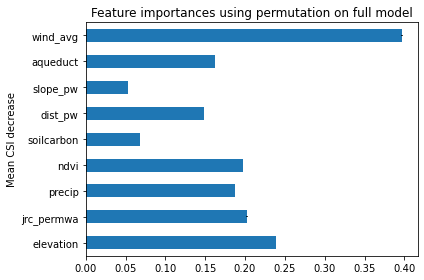

In [26]:
fig, ax = plt.subplots()
mean_pis.plot.barh(yerr=pi.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean CSI decrease")
fig.tight_layout()

if savefig:
    fig.savefig(join(imdir, "rf", f"RF permutation feature rankings temporal{temporal}"))

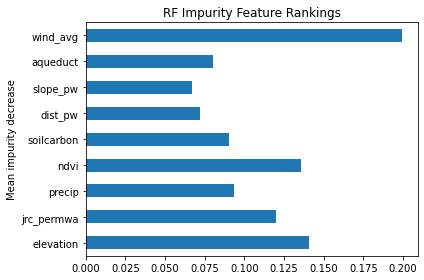

In [30]:
# plot feature rankings
savefig = True
stds = [np.std([rank[feature] for rank in rankings]) for feature in features]
means = [np.mean([rank[feature] for rank in rankings]) for feature in features]

mean_rankings = pd.Series(means, index=features)

fig, ax = plt.subplots()
mean_rankings.plot.barh(yerr=stds, ax=ax)
ax.set_title("RF Impurity Feature Rankings")
ax.set_ylabel("Mean impurity decrease")
fig.tight_layout()

if savefig:
    fig.savefig(join(imdir, "rf", f"RF impurity feature rankings temporal{temporal}"))

In [15]:
logger.info("NEW RUN")
logger.info(f"Loading data with:\ntemporal={temporal},\nbinary={binary},\nstorm subset: {storm}")
logger.info(f"Run with {nfeatures} features: {features}")
logger.info(f"Number of unique images/subregions: {gdf['event'].nunique()}")

logger.info(f"Zeros: {n0}")
logger.info(f"Ones: {n1}")

logger.info(f"Starting {K}-fold CV with seed={SEED}")
logger.info(f"Running random forest with params:\n{best_params}")

logger.info("Mean CSI {0:0.2f}".format(np.mean(CSIs)))
logger.info("CSI Std. Dev {0:0.2f}".format(np.std(CSIs)))

logger.info(f"Impurity-based importance: mean rankings:\n{mean_rankings}")
logger.info(f"Permutation-based importance: mean rankings:\n{mean_pis}")

logger.info("END OF RUN\n\n\n")